# Интро

In [ ]:
#Libraries
!pip install pdfplumber pandas numpy gdown
import pdfplumber
import logging
import pandas as pd
import numpy as np
import re
import os
from pathlib import Path
import glob
import gdown
#For ML part
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Описание входных данных

## pdf-файл Рацион(отчеты ЖК):
### Таблица №1 "Рецепт"
- Ингредиенты
- СВ% — содержание сухого вещества компонента (СВ / ГП)
- ГП кг — масса корма
- СВ кг — масса сухого вещества
- %ГП — массовая доля компонента в рационе
> **%СВ — массовая доля сухого вещества (наиболее важный параметр)**

Иногда корм закодирован, и имеет следующий вид:
3637.07.05.02.1.24.
- **** — номер подразделения
- ** — номер хранилища
- ** — наименование культуры
- ** — **вид корма**
*   01 -сенаж
*   02-силос
*   07-корнаж

- *— номер укоса
- *—год заготовки

Предлагаю сфокусироваться на виде корма(4 позиция в кодификаторе) и потом если будет время включить в модель как рандомные/фиксированные эффекты
### Таблица №2 (Полный анализ: Лактирующая корова) — анализ питательности нутриентов
- Нутриент — название добавки
- Единица — единица измерения соответствующая ячейке в столбце "СВ"
> **СВ — массовая доля нутриента (опять же основной параметр)**
- Содержание — масса в рационе
- Единица — единица измерения соответствующая ячейке в столбце "Содержание"

#Наиболее важные параметры влияющие на молочный жир, которые укзаны в ТЗ:

##**Анализ**
*   ЧЭЛ 3x NRC (МДжоуль/кг)
*   СП (%)
*   Крахмал (%)
*   RD Крахмал 3xУровень 1 (%)
*   Сахар (ВРУ) (%)
*   НСУ (%)
*   НВУ (%)
*   aNDFom (%)
*   CHO B3 pdNDF (%)
*   Растворимая клетчатка (%)
*   aNDFom фуража (%)
*   peNDF (%)
*   CHO B3 медленная фракция (%)
*   CHO C uNDF (%)
*   СЖ (%)
*   ОЖК (%)
*   K (%)

---
## NCPS
###**Углеводы**
* НДК в рационе (% СВ)
* аНДК фуража (% СВ)
* peNDF (% СВ)
* CHO B3 fast pool Потребление (% СВ)
* CHO B3 slow pool Потребление (% СВ)
* uNDF Потребление (% СВ)
* peuNDF Потребление (% СВ)
* NFC рациона (% СВ)
* Расторим. Клетчатка деградир. (% СВ)\
###**Протеин**
* РДП (%СП)
* Растворимый протеин (%СП)\
###**Длинноцепочечные жирные кислоты**
* LCFA - ДЦЖК потребление (г/дн)
* LCFA -ДЦЖК непредельные (г/дн)
* LCFA -ДЦЖК липолизированные (г/дн)
* LCFA -ДЦЖК кишечника (г/дн)
* LCFA -ДЦЖК переваримые (г/дн)
###**DCAD**
* [Na + K] - [Cl + S] (mEq/100 г)
###**ЖК**
* общие НЖК
* общие ПНЖК
* RUFAL
* C12:0
* C14:0
* C16:0
* C16:1
* C18:0
* C18:1
* C18:1Т
* C18:1С
* C18:3
---

#Парсинг pdf

In [ ]:
# @title
# Логгирование вместо print
logging.basicConfig(
    filename='parse_pdf.log',       # файл, куда будет писаться лог
    level=logging.INFO,             # уровень сообщений (INFO, WARNING, ERROR)
    format='%(asctime)s - %(levelname)s - %(message)s',
    encoding='utf-8'
)


In [ ]:
# @title
def parse_pdf_files_from_directories(root_directories, output_dir=None):
    """
    Parses PDF files from multiple directories and extracts recipe, analysis,
    and summary analysis data ("Сводный анализ: Лактирующая корова")
    """

    def extract_tables_from_pdf(pdf_path):
        """Извлекает таблицы и текст из PDF"""
        tables_data = {}
        try:
            with pdfplumber.open(pdf_path) as pdf:
                for page_num, page in enumerate(pdf.pages):
                    tables = page.extract_tables()
                    for table_num, table in enumerate(tables):
                        if table and len(table) > 1:
                            key = f"page_{page_num + 1}_table_{table_num + 1}"
                            tables_data[key] = table

                    text = page.extract_text()
                    if text:
                        tables_data[f"page_{page_num + 1}_text"] = text
        except Exception as e:
            logging.exception(f"Error extracting from {pdf_path}: {e}")
        return tables_data

    def parse_recipe_from_tables(tables_data, file_name, file_path):
        """Парсит таблицу с ингредиентами"""
        recipe_data = []

        for table_key, table in tables_data.items():
            if 'table' in table_key:
                header_row = None
                for i, row in enumerate(table):
                    if row and any('Ингредиенты' in str(cell) for cell in row if cell):
                        header_row = i
                        break

                if header_row is not None:
                    for row in table[header_row:]:
                        if row and len(row) > 3 and row[0] and 'Ингредиенты' not in str(row[0]):
                            cleaned_row = [str(cell).strip() if cell else '' for cell in row]

                            ingredient_data = {
                                'Ингредиенты': cleaned_row[0],
                                'СВ_%': cleaned_row[1] if len(cleaned_row) > 1 else '',
                                'ГП_кг': cleaned_row[2] if len(cleaned_row) > 2 else '',
                                'СВ_кг': cleaned_row[3] if len(cleaned_row) > 3 else '',
                                '%_ГП': cleaned_row[4] if len(cleaned_row) > 4 else '',
                                '%_СВ': cleaned_row[5] if len(cleaned_row) > 5 else '',
                                'рацион': file_name.replace('.pdf', ''),
                                'директория': os.path.dirname(file_path)
                            }
                            recipe_data.append(ingredient_data)
                    break

        return pd.DataFrame(recipe_data)

    def parse_analysis_from_tables(tables_data, file_name, file_path):
        """Парсит основные показатели анализа (Сводный анализ: Лактирующая корова)"""
        import re

        # Метаданные
        analysis_data = {
            'рацион': file_name.replace('.pdf', ''),
            'исходный_файл': file_name,
            'путь_к_файлу': file_path,
            'директория': os.path.dirname(file_path)
        }

        # 🔑 Единый список ключевых параметров (без повторов)
        key_parameters = [
            'СП', 'aNDFom',
            'CHO C uNDF', 'Сахар (ВРУ)', 'Крахмал', 'Растворимая', 'Растворимая клетчатка',
            'НВУ', 'СЖ', 'ОЖК', 'Зола', 'Ca', 'P', 'Mg', 'K', 'Na', 'peNDF'
        ]

        # Проходим по всем таблицам
        for table_key, table in tables_data.items():
            if 'table' not in table_key:
                continue

            for row in table:
                if not row or len(row) < 3:
                    continue

                nutrient = str(row[0]).strip()
                if not nutrient:
                    continue

                # Проверяем, есть ли этот параметр в списке
                for kp in key_parameters:
                    if nutrient.strip().lower().startswith(kp.lower()):
                        value = row[2] if len(row) > 2 else ''
                        if value:
                            val = str(value).replace(',', '.').replace(' ', '')
                            match = re.search(r'[-+]?\d*\.?\d+', val)
                            if match:
                                try:
                                    analysis_data[kp] = float(match.group())
                                except:
                                    analysis_data[kp] = match.group()
                            else:
                                analysis_data[kp] = None
                        else:
                            analysis_data[kp] = None
                        break

        # 🧩 Добавляем отсутствующие ключи, чтобы все строки имели одинаковые столбцы
        for kp in key_parameters:
            if kp not in analysis_data:
                analysis_data[kp] = None

        return analysis_data


    def parse_summary_analysis_from_tables(tables_data, file_name, file_path):
        """Парсит таблицу 'Сводный анализ: Лактирующая корова'"""
        import re
        summary_rows = []

        for table_key, table in tables_data.items():
            if 'table' not in table_key:
                continue

            # Ищем таблицу, начинающуюся с "Нутриент"
            header_found = False
            for i, row in enumerate(table):
                if row and any('Нутриент' in str(cell) for cell in row if cell):
                    header_found = True
                    header_index = i
                    break

            if not header_found:
                continue

            # Считываем строки таблицы
            for row in table[header_index + 1:]:
                if not row or len(row) < 4:
                    continue

                nutrient = str(row[0]).strip()
                if not nutrient or nutrient.lower().startswith('сводка'):
                    break  # конец таблицы

                def to_float(value):
                    try:
                        v = str(value).replace(',', '.').replace(' ', '')
                        match = re.search(r'[-+]?\d*\.?\d+', v)
                        return float(match.group()) if match else None
                    except:
                        return None

                summary_rows.append({
                    'Нутриент': nutrient,
                    'СВ': to_float(row[2]),
                    'Содержание': to_float(row[3]),
                    'рацион': file_name.replace('.pdf', ''),
                    'исходный_файл': file_name,
                    'путь_к_файлу': file_path,
                    'директория': os.path.dirname(file_path)
                })

        return pd.DataFrame(summary_rows)

    def decode_feed_type(ingredient):
        """Определяет вид корма по коду"""
        if isinstance(ingredient, str):
            match = re.search(r'(\d{4})\.(\d{2})\.(\d{2})\.(\d{2})', str(ingredient))
            if match:
                code = match.group(4)
                if code == '01':
                    return 'сенаж'
                elif code == '02':
                    return 'силос'
                elif code == '07':
                    return 'корнаж'
        return 'другое'

    # === Основная логика ===
    if output_dir is None:
        output_dir = os.getcwd()

    if isinstance(root_directories, str):
        root_directories = [root_directories]

    pdf_files = []
    for root_dir in root_directories:
        if os.path.exists(root_dir):
            found_files = glob.glob(os.path.join(root_dir, '**', '*.pdf'), recursive=True)
            pdf_files.extend(found_files)
        else:
            logging.warning(f"Directory not found: {root_dir}")

    logging.info(f"Found {len(pdf_files)} PDF files")

    all_recipes = []
    all_analyses = []
    all_summary = []
    stats = {
        'total_files': len(pdf_files),
        'successful_files': 0,
        'failed_files': 0,
        'files_with_recipes': 0,
        'files_with_analysis': 0,
        'files_with_summary': 0,
        'failed_file_list': []
    }

    for pdf_path in pdf_files:
        try:
            file_name = os.path.basename(pdf_path)
            logging.info(f"Processing: {pdf_path}")

            tables_data = extract_tables_from_pdf(pdf_path)

            recipe_df = parse_recipe_from_tables(tables_data, file_name, pdf_path)
            if not recipe_df.empty:
                all_recipes.append(recipe_df)
                stats['files_with_recipes'] += 1

            analysis_dict = parse_analysis_from_tables(tables_data, file_name, pdf_path)
            if len(analysis_dict) > 1:
                all_analyses.append(analysis_dict)
                stats['files_with_analysis'] += 1

            summary_df = parse_summary_analysis_from_tables(tables_data, file_name, pdf_path)
            if not summary_df.empty:
                all_summary.append(summary_df)
                stats['files_with_summary'] += 1

            stats['successful_files'] += 1
            logging.info(f"✓ Successfully processed: {file_name}")

        except Exception as e:
            stats['failed_files'] += 1
            stats['failed_file_list'].append((pdf_path, str(e)))
            logging.error(f"✗ Failed to process {pdf_path}: {e}")

    # === Объединение результатов ===
    results = {}

    if all_recipes:
        recipes_combined = pd.concat(all_recipes, ignore_index=True)
        recipes_combined['вид_корма'] = recipes_combined['Ингредиенты'].apply(decode_feed_type)
        results['recipes'] = recipes_combined
    else:
        results['recipes'] = pd.DataFrame()

    results['analyses'] = pd.DataFrame(all_analyses) if all_analyses else pd.DataFrame()
    results['summary_analysis'] = pd.concat(all_summary, ignore_index=True) if all_summary else pd.DataFrame()
    results['statistics'] = stats

    # === Сохранение ===
    os.makedirs(output_dir, exist_ok=True)

    if not results['recipes'].empty:
        path = os.path.join(output_dir, 'all_recipes_combined.csv')
        results['recipes'].to_csv(path, index=False, encoding='utf-8-sig')
        results['recipe_file_path'] = path

    if not results['analyses'].empty:
        path = os.path.join(output_dir, 'all_analyses_combined.csv')
        results['analyses'].to_csv(path, index=False, encoding='utf-8-sig')
        results['analysis_file_path'] = path

    if not results['summary_analysis'].empty:
        path = os.path.join(output_dir, 'summary_analysis_combined.csv')
        results['summary_analysis'].to_csv(path, index=False, encoding='utf-8-sig')
        results['summary_file_path'] = path

    stats_df = pd.DataFrame([stats])
    stats_path = os.path.join(output_dir, 'processing_statistics.csv')
    stats_df.to_csv(stats_path, index=False)
    results['statistics_file_path'] = stats_path

    return results


In [ ]:
# @title
# Set root and output directories
results = parse_pdf_files_from_directories(
    root_directories='/content/drive/MyDrive/Khacathon/prim_data/primary_pdfs',
    output_dir='/content/drive/MyDrive/Khacathon/output/'
)

#Выгрузка

In [112]:
def read_csv_from_gdrive(url: str) -> pd.DataFrame:
    """
    Загружает CSV-файл с Google Drive или Google Sheets по ссылке.
    Возвращает pandas.DataFrame.

    Поддерживаются:
    - Ссылки формата https://drive.google.com/file/d/<ID>/view?usp=sharing
    - Ссылки на Google Sheets: https://docs.google.com/spreadsheets/d/<ID>/edit
    """

    # Google Sheets
    if "spreadsheets" in url:
        match = re.search(r"/spreadsheets/d/([a-zA-Z0-9-_]+)", url)
        if not match:
            raise ValueError("Невозможно извлечь ID из ссылки Google Sheets")
        sheet_id = match.group(1)

        # пробуем извлечь имя листа, если указано
        sheet_match = re.search(r"gid=(\d+)", url)
        sheet_part = f"&gid={sheet_match.group(1)}" if sheet_match else ""

        sheet_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv{sheet_part}"
        return pd.read_csv(sheet_url, encoding='utf-8-sig', on_bad_lines='skip')

    # Google Drive file
    elif "drive.google.com" in url:
        match = re.search(r"/d/([a-zA-Z0-9-_]+)", url)
        if not match:
            raise ValueError("Невозможно извлечь ID из ссылки Google Drive")
        file_id = match.group(1)

        download_url = f"https://drive.google.com/uc?export=download&id={file_id}"
        output_path = "temp_download.csv"

        # пробуем скачать с помощью gdown
        gdown.download(download_url, output_path, quiet=False)
        return pd.read_csv(output_path)

    else:
        raise ValueError("Ссылка не похожа на Google Drive или Google Sheets")


In [113]:
# Скачиваем данные о нутриентах (сводный анализ, лактирующая корова)
url1 = "https://drive.google.com/file/d/1GJPKJpK8M7y-PDqc78TbXphpai3QWvgd/view?usp=sharing"
nutrients = read_csv_from_gdrive(url1)

Downloading...
From: https://drive.google.com/uc?export=download&id=1GJPKJpK8M7y-PDqc78TbXphpai3QWvgd
To: /content/temp_download.csv
100%|██████████| 37.9k/37.9k [00:00<00:00, 21.8MB/s]


#Инфо о таблицах

Красным отмечено чего нет в пдф файлах
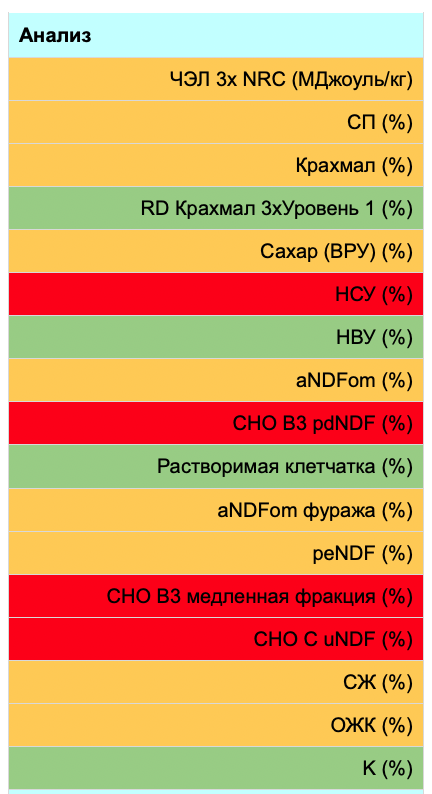

еще момент среди

# Визуализация


In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

nutrient_cols = ['трав_сен', 'конц_зерн', 'масличн', 'жир', 'пром_отх', 'мин_техно',
 'сп', 'крахмал', 'andfom', 'сахар (вру)', 'нву', 'ожк', 'k']

acid_cols = ['масляная', 'капроновая', 'каприловая', 'каприновая', 'деценовая', 'лауриновая',
       'миристиновая', 'миристолеиновая', 'пальмитиновая', 'пальмитолеиновая',
       'стеариновая', 'олеиновая', 'линолевая', 'линоленовая', 'арахиновая']

df = training_df.copy()

# оставляем только нужные колонки
df = df[[c for c in nutrient_cols + acid_cols if c in df.columns]].copy()

# корреляционная матрица
corr_matrix = df.corr()

acid_vs_nutrient_corr = corr_matrix.loc[acid_cols, nutrient_cols]
print("\nКорреляции кислот с нутриентами:")
print(acid_vs_nutrient_corr.round(3))




Корреляции кислот с нутриентами:
                  трав_сен  конц_зерн  масличн    жир  пром_отх  мин_техно  \
масляная            -0.044      0.014    0.090 -0.167    -0.042      0.149   
капроновая          -0.038      0.113   -0.144 -0.211     0.212     -0.095   
каприловая          -0.055      0.105   -0.112 -0.133     0.300     -0.304   
каприновая          -0.027      0.078    0.011 -0.064     0.255     -0.329   
деценовая            0.027     -0.001   -0.120 -0.230     0.258     -0.131   
лауриновая          -0.003      0.041   -0.054 -0.055     0.314     -0.244   
миристиновая         0.083      0.063   -0.171 -0.107     0.188     -0.349   
миристолеиновая      0.151      0.004   -0.220 -0.115     0.260     -0.137   
пальмитиновая        0.099     -0.069   -0.133 -0.024     0.334     -0.082   
пальмитолеиновая     0.077     -0.183    0.010  0.094     0.097      0.579   
стеариновая         -0.080      0.037    0.152 -0.019    -0.341     -0.020   
олеиновая           -0.045    

In [ ]:
# построение графиков
plots_dir = Path('plots_acids_vs_nutrients')
plots_dir.mkdir(parents=True, exist_ok=True)

for acid in acid_cols:
    for nut in nutrient_cols:
        if acid in df.columns and nut in df.columns:
            plt.figure(figsize=(5, 4))
            plt.scatter(df[nut], df[acid], alpha=0.7)
            plt.xlabel(nut)
            plt.ylabel(acid)
            plt.title(f"{acid} vs {nut}")
            plt.tight_layout()
            plt.savefig(plots_dir / f"{acid}_vs_{nut}.png", dpi=150)
            plt.close()

print(f"Графики сохранены в папке: {plots_dir.resolve()}")


# ML-модель на категориях "Травяные сенажи", "Зерновые+концентраты" и т.п.

In [213]:
#Libraries
!pip install pdfplumber pandas numpy gdown
import pdfplumber
import pandas as pd
import numpy as np
import re
import os
from pathlib import Path
import glob
import gdown
#For ML part
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [214]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [215]:
# @title
def read_csv_from_gdrive(url: str) -> pd.DataFrame:
    """
    Загружает CSV-файл с Google Drive или Google Sheets по ссылке.
    Возвращает pandas.DataFrame.

    Поддерживаются:
    - Ссылки формата https://drive.google.com/file/d/<ID>/view?usp=sharing
    - Ссылки на Google Sheets: https://docs.google.com/spreadsheets/d/<ID>/edit
    """

    # Google Sheets
    if "spreadsheets" in url:
        match = re.search(r"/spreadsheets/d/([a-zA-Z0-9-_]+)", url)
        if not match:
            raise ValueError("Невозможно извлечь ID из ссылки Google Sheets")
        sheet_id = match.group(1)

        # пробуем извлечь имя листа, если указано
        sheet_match = re.search(r"gid=(\d+)", url)
        sheet_part = f"&gid={sheet_match.group(1)}" if sheet_match else ""

        sheet_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv{sheet_part}"
        return pd.read_csv(sheet_url, encoding='utf-8-sig', on_bad_lines='skip')

    # Google Drive file
    elif "drive.google.com" in url:
        match = re.search(r"/d/([a-zA-Z0-9-_]+)", url)
        if not match:
            raise ValueError("Невозможно извлечь ID из ссылки Google Drive")
        file_id = match.group(1)

        download_url = f"https://drive.google.com/uc?export=download&id={file_id}"
        output_path = "temp_download.csv"

        # пробуем скачать с помощью gdown
        gdown.download(download_url, output_path, quiet=False)
        return pd.read_csv(output_path)

    else:
        raise ValueError("Ссылка не похожа на Google Drive или Google Sheets")


In [216]:
#загрузка с гугл диска напрямую
url1 = "https://drive.google.com/file/d/1GJPKJpK8M7y-PDqc78TbXphpai3QWvgd/view?usp=sharing"
analyses_df = read_csv_from_gdrive(url1)
url2 = "https://docs.google.com/spreadsheets/d/1rXqVCfBKCVTwUGVxXHaV73-ZB4YeEciq2tJ9AWtOT9s/edit?usp=sharing"
recipes_df = read_csv_from_gdrive(url2)
url3='https://docs.google.com/spreadsheets/d/1FJLbmeOy3q9CVcBa9loRa-SrMd0CsARWn9ypQKd6WpY/edit?usp=sharing'
fatty_acids_df = read_csv_from_gdrive(url3)

print("📊 Данные загружены:")
print(f"Анализы: {analyses_df.shape}")
print(f"Рецепты: {recipes_df.shape}")
print(f"Жирные кислоты: {fatty_acids_df.shape}")

Downloading...
From: https://drive.google.com/uc?export=download&id=1GJPKJpK8M7y-PDqc78TbXphpai3QWvgd
To: /content/temp_download.csv
100%|██████████| 37.9k/37.9k [00:00<00:00, 55.8MB/s]


📊 Данные загружены:
Анализы: (94, 22)
Рецепты: (1128, 11)
Жирные кислоты: (106, 23)


ожидаемый результат Анализы: (94, 16)
Рецепты: (1128, 11)
Жирные кислоты: (106, 22)

Работаем с таблицей "рецепты". Выкидываем "общие значения"

In [118]:
recipes_df.drop(recipes_df[recipes_df['Ингредиенты'] =='Общие значения'].index, inplace = True)

Извлекаем числовые коды из названий ингредиентов, номер культуры и вида корма сохраняем в колонки culture, feed_code

In [119]:
def extract_codes(text):
    pattern = r'(\d{4}\.\d{2}\.\d{2}\.\d{1,2})'
    match = re.search(pattern, str(text))
    if match:
        code = match.group(1)
        parts = code.split('.')
        if len(parts) >= 4:
            culture_code = parts[2]
            feed_code = parts[3]
            return culture_code, feed_code
    return None, None

In [120]:
recipes_df['culture'], recipes_df['feed_code'] = zip(*recipes_df['Ингредиенты'].apply(extract_codes))

In [121]:

culture_dict = {
    "01": "Люцерна","02": "Эспарцет","03": "Многолетние травы","04": "Луговые травы",
    "05": "Кукуруза","06": "Суданская трава","07": "Вико-овес","08": "Люцерна 1 г.ж.",
    "09": "Клевер + Тимофеевка","10": "Однолетние травы","11": "Райграс","12": "Тритикале",
    "13": "Рожь","14": "Клевер","15": "Пшеница","16": "Разнотравье","17": "Горох","18": "Зерносмесь",
    "19": "Ячмень","20": "Шрот соевый","21": "Шрот рапсовый","22": "Жмых рапсовый","23": "Жмых льняной",
    "24": "Барда","25": "Шрот подсолнечный","26": "Глютен","27": "Могар","28": "Амарант","29": "Сорго",
    "30": "Козлятник","31": "Овес","32": "Вика + тритикале","33": "Рожь + тритикале","34": "Эспарцет + костер",
    "35": "Овес + горох","36": "Кострец","37": "Эспарцет + житняк","38": "Тимофеевка",
    "39": "Соя","40": "Рапс","41": "Свекла"
}


Далее по словам ищем ингредиенты, подходящие категориям 1 - "травяные сенажи/сено", 2 - зерновые/концентраты, 3 - масличные/шроты, 4 - жир, 5 - отходы производства, 6 - минеральные добавки и премиксы

In [122]:
def extract_words(row):
    text = str(row.get('Ингредиенты', '')).lower()
    culture_code = str(row.get('culture', ''))
    feed_code = str(row.get('feed_code', ''))

    categories = {
        1: [
            r'люцерн', r'клевер', r'тимофеевк', r'лугов', r'однолетн', r'многолетн', r'разнотрав',
            r'сенаж', r'сено', r'тритикале', r'с-ж', r'c-ж', r'судан'
        ],
        2: [
            r'кукуруз', r'пшениц', r'ячмен', r'зерносмес', r'концентрат', r'корнаж',r'к-ж', r'силос',
            r'солом', r'зерно', r'комби', r'кк', r'фураж', r'кормосмес', r'с-'
        ],
        3: [
            r'жмых', r'шрот', r'соев', r'рапс', r'льнян', r'подсолнечн', r'оболочк'
        ],
        4: [
            r'жир'
        ],
        5: [
            r'свекл', r'свёкл', r'жом', r'паток', r'пивн', r'дробин', r'рож', r'дрожж'
        ],
        6: [
            r'добавк', r'кальци', r'калия', r'премикс', r'сода', r'соль', r'поташ', r'мел'
        ]
    }

    if culture_code and culture_code in culture_dict:
        culture = culture_dict[culture_code].lower()
        if re.search(r'люцерн|клевер|тимофеевк|лугов|однолетн|многолетн|разнотрав|эсп|судан|тритик', culture):
            return 1
        if re.search(r'кукуруз|пшениц|ячмен|зерносмес|концентрат', culture):
            return 2
        if re.search(r'шрот|жмых|соев|рапс|льн|подсолнеч', culture):
            return 3

    for cat, patterns in categories.items():
        for pat in patterns:
            if re.search(pat, text, flags=re.IGNORECASE):
                return cat
    return None


In [123]:
recipes_df['category'] = recipes_df.apply(extract_words, axis=1)

In [124]:
for col in ['СВ_%', 'ГП_кг', 'СВ_кг', '%_ГП', '%_СВ']:
  recipes_df[col] = recipes_df[col].str.replace(',','.').str.replace('%', '')
  recipes_df[col] = recipes_df[col].astype(float)

In [125]:
fatty_acids_df.columns

Index(['Регион', 'Дата', 'Наименование ЖК', 'Количество рационов',
       'Лаборатория', 'Рацион', 'Масляная', 'Капроновая', 'Каприловая',
       'Каприновая', 'Деценовая', 'Лауриновая', 'Миристиновая',
       'Миристолеиновая', 'Пальмитиновая', 'Пальмитолеиновая', 'Стеариновая',
       'Олеиновая', 'Линолевая', 'Линоленовая', 'Арахиновая', 'Бегеновая',
       'Прочие'],
      dtype='object')

In [126]:
fatty_acids_df['Бегеновая'] = fatty_acids_df['Бегеновая'].replace('<0,05', '0,025')

In [127]:
for col in ['Масляная', 'Капроновая', 'Каприловая', 'Каприновая', 'Деценовая',
       'Лауриновая', 'Миристиновая', 'Миристолеиновая', 'Пальмитиновая',
       'Пальмитолеиновая', 'Стеариновая', 'Олеиновая', 'Линолевая',
       'Линоленовая', 'Арахиновая', 'Бегеновая']:
       fatty_acids_df[col] = fatty_acids_df[col].str.replace(',','.')
       fatty_acids_df[col] = fatty_acids_df[col].astype(float)

In [129]:
def aggregate_recipe_data(recipes_df, composition_df):
    """Агрегирует данные по видам ингредиентов и нутриентам для каждого рациона """

    category_map = {
        1: 'трав_сен',
        2: 'конц_зерн',
        3: 'масличн',
        4: 'жир',
        5: 'пром_отх',
        6: 'мин_техно'
    }

    # Суммируем значения %_СВ по рациону и категории
    category_agg = (
        recipes_df
        .groupby(['рацион', 'category'], as_index=False)['%_СВ']
        .sum()
    )

    # Преобразуем в широкую таблицу
    category_pivot = (
        category_agg
        .pivot(index='рацион', columns='category', values='%_СВ')
        .fillna(0)
        .rename(columns=category_map)
    )

    # Преобразуем обратно в обычный DataFrame
    category_pivot = category_pivot.reset_index()

    # Оставляем нужные колонки из второй таблицы
    composition_cols = [
        'рацион', 'СП', 'Крахмал', 'aNDFom',
        'Сахар (ВРУ)', 'НВУ', 'ОЖК', 'K'
    ]
    composition_subset = composition_df[composition_cols]

    # Объединяем по рациону
    merged_df = pd.merge(category_pivot, composition_subset, on='рацион', how='left')

    return merged_df


In [130]:
recipes_aggregated = aggregate_recipe_data(recipes_df,analyses_df)
print(f"Агрегированные рецепты: {recipes_aggregated.shape}")

Агрегированные рецепты: (93, 14)


Возьмем нутриенты, которые повторяются во всех рационах - настоятельный совет организаторов (рационов 94, я брала те нутриенты, которые встречаются 92 и более раз)


Добавляем рационы "50 на 50" там, где 2 рациона и один анализ молока

In [131]:
def clean_name(name):
    # убираем скобки и содержимое, лишние пробелы и спецсимволы
    name = re.sub(r'\(.*?\)', '', str(name))
    name = re.sub(r'[^а-яА-Яa-zA-Z0-9_\.\s-]', '', name)
    name = re.sub(r'\s+', ' ', name)
    return name.strip().lower()

In [132]:
from difflib import get_close_matches

# чистим имена колонок
fatty_acids_df.columns = [c.strip().lower() for c in fatty_acids_df.columns]
recipes_aggregated.columns = [c.strip().lower() for c in recipes_aggregated.columns]


def add_mixed_rations_fuzzy(aggregated_df, fatty_df):
    aggregated = aggregated_df.copy()
    aggregated['рацион_clean'] = aggregated['рацион'].apply(clean_name)
    agg_names = aggregated['рацион_clean'].tolist()

    new_rows = []
    warnings = []

    numeric_cols = aggregated.select_dtypes(include=np.number).columns.tolist()

    for _, row in fatty_df.iterrows():
        rname = str(row['рацион'])
        if '+' in rname:
            parts = [p.strip() for p in rname.split('+') if p.strip()]
            clean_parts = [clean_name(p) for p in parts[:2]]
            matched_rows = []

            for p in clean_parts:
                match = get_close_matches(p, agg_names, n=1, cutoff=0.5)
                if match:
                    matched_rows.append(aggregated[aggregated['рацион_clean'] == match[0]].iloc[0])
                else:
                    warnings.append(f'Рацион не найден: "{p}"')

            if len(matched_rows) == 2:
                # усредняем только числовые колонки
                mix_numeric = (matched_rows[0][numeric_cols] + matched_rows[1][numeric_cols]) / 2
                mix = matched_rows[0].copy()
                mix[numeric_cols] = mix_numeric
                mix['рацион'] = "_".join([p.replace(' ', '_') for p in parts[:2]]) + "_mix"
                new_rows.append(mix)
        else:
            continue

    if new_rows:
        mix_df = pd.DataFrame(new_rows)
        aggregated = pd.concat([aggregated, mix_df], ignore_index=True)

    aggregated = aggregated.drop(columns=['рацион_clean'], errors='ignore')
    return aggregated, warnings




In [133]:
# добавили микс-рационы
recipes_aggregated, warnings = add_mixed_rations_fuzzy(recipes_aggregated, fatty_acids_df)
print(recipes_aggregated.tail())
for w in warnings:
    print(w)

                                                                                    рацион  \
95    ЖК_Бобров-2_Д1_(КК-11)_21.05.25(1)_ЭНАВ_ЖК_Бобров-2_Д1_(КК-11)_21.05.25_(2)_ЭНАВ_mix   
96  Отчет_Д1_Гусево__Уланово_18.06.25_(2)_КНЗ_Отчет_Д1_Гусево_Уланово_18.06.25_(1)_КНЗ_mix   
97  Отчет_Д1_Гусево__Уланово_18.06.25_(2)_КНЗ_Отчет_Д1_Гусево_Уланово_18.06.25_(1)_КНЗ_mix   
98                Отчет_Д1_Л=1_Гусево_11.07.25_(2)_КНЗ_Отчет_Д1_Гусево__(11.07.25)_КНЗ_mix   
99                Отчет_Д1_Л=1_Гусево_11.07.25_(2)_КНЗ_Отчет_Д1_Гусево__(11.07.25)_КНЗ_mix   

    трав_сен  конц_зерн  масличн  жир  пром_отх  мин_техно       сп   крахмал  \
95    14.040     57.820   17.680  0.0     10.46        0.0  16.6600  25.81000   
96    14.135     57.355   19.435  1.4      7.68        0.0  17.2328  28.68015   
97    14.135     57.355   19.435  1.4      7.68        0.0  17.2328  28.68015   
98    13.300     57.840   19.785  1.4      7.68        0.0  17.0101  28.44005   
99    13.300     57.840   19.7

Создаем датасет для обучения

In [135]:
def create_training_dataset(recipes_aggregated, fatty_acids_df, fillna=False, fuzzy_cutoff=0.5):
    agg = recipes_aggregated.copy()
    fat = fatty_acids_df.copy()

    agg.columns = [c.strip().lower() for c in agg.columns]
    fat.columns = [c.strip().lower() for c in fat.columns]

    if 'рацион' not in agg.columns or 'рацион' not in fat.columns:
        raise KeyError('Ожидается колонка "рацион" в обоих датафреймах')

    agg['рацион_clean'] = agg['рацион'].astype(str).apply(clean_name)
    fat['рацион_raw'] = fat['рацион'].astype(str)
    fat['рацион_clean'] = fat['рацион_raw'].apply(clean_name)
    fat['наименование жк'] = fat.get('наименование жк', fat.get('наименование_жк', pd.Series(['']*len(fat))))

    agg_names = agg['рацион_clean'].tolist()

    possible_targets = ['масляная','капроновая','каприловая','каприновая','деценовая',
                        'лауриновая','миристиновая','миристолеиновая','пальмитиновая',
                        'пальмитолеиновая','стеариновая','олеиновая','линолевая',
                        'линоленовая','арахиновая']
    targets = [t for t in possible_targets if t in fat.columns]

    numeric_feats = agg.select_dtypes(include=[np.number]).columns.tolist()

    rows = []
    warnings = []

    for _, frow in fat.iterrows():
        raw_name = frow['рацион_raw']
        clean = frow['рацион_clean']
        qty = frow.get('количество рационов', None)
        try:
            qty = int(qty) if not pd.isna(qty) else (2 if '+' in raw_name else 1)
        except:
            qty = (2 if '+' in raw_name else 1)

        if '+' in raw_name or qty == 2:
            parts = [p.strip() for p in raw_name.split('+') if p.strip()]
            if len(parts) < 2:
                parts = re.split(r'\+|/', raw_name)
                parts = [p.strip() for p in parts if p.strip()]
            parts = parts[:2]
            found = []
            for p in parts:
                p_clean = clean_name(p)
                if p_clean in agg_names:
                    found.append(agg.loc[agg['рацион_clean'] == p_clean].iloc[0])
                else:
                    match = get_close_matches(p_clean, agg_names, n=1, cutoff=fuzzy_cutoff)
                    if match:
                        found.append(agg.loc[agg['рацион_clean'] == match[0]].iloc[0])
                    else:
                        warnings.append(f'Не найден рацион для части "{p}" из "{raw_name}"')
            if len(found) == 2:
                f0 = found[0]
                f1 = found[1]
                mixed_numeric = (f0[numeric_feats].astype(float).fillna(0) + f1[numeric_feats].astype(float).fillna(0)) / 2
                base = f0.copy()
                base[numeric_feats] = mixed_numeric
                base['рацион'] = f"{clean_name(parts[0])}_{clean_name(parts[1])}_mix"
                record = {c: base[c] for c in numeric_feats}
                for t in targets:
                    record[t] = frow.get(t, np.nan)
                record['рацион_source'] = raw_name
                record['наименование_жк'] = frow.get('наименование жк', frow.get('наименование_жк', ''))
                rows.append(record)
            else:
                warnings.append(f'Не удалось создать mix для "{raw_name}"')
        else:
            match_name = None
            if clean in agg_names:
                match_name = clean
            else:
                match = get_close_matches(clean, agg_names, n=1, cutoff=fuzzy_cutoff)
                if match:
                    match_name = match[0]
            if match_name:
                source = agg.loc[agg['рацион_clean'] == match_name].iloc[0]
                record = {c: float(source[c]) if c in numeric_feats else source[c] for c in numeric_feats}
                for t in targets:
                    record[t] = frow.get(t, np.nan)
                record['рацион_source'] = raw_name
                record['наименование_жк'] = frow.get('наименование жк', frow.get('наименование_жк', ''))
                rows.append(record)
            else:
                warnings.append(f'Рацион не найден: "{raw_name}"')

    if not rows:
        training_df = pd.DataFrame()
    else:
        training_df = pd.DataFrame(rows)
        if fillna:
            training_df = training_df.fillna(0)

    return training_df, warnings


Проверим гипотезу о том, что странные данные -  из альтернативных лабораторий (частично подтвердилась, но есть нюансы)

In [179]:
training_df['лаборатория'] = fatty_acids_df['лаборатория']

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

nutrient_cols = ['трав_сен', 'конц_зерн', 'масличн', 'жир', 'пром_отх', 'мин_техно',
 'сп', 'крахмал', 'andfom', 'сахар (вру)', 'нву', 'ожк', 'k']

acid_cols = ['масляная', 'капроновая', 'каприловая', 'каприновая', 'деценовая', 'лауриновая',
       'миристиновая', 'миристолеиновая', 'пальмитиновая', 'пальмитолеиновая',
       'стеариновая', 'олеиновая', 'линолевая', 'линоленовая', 'арахиновая']

try:
    df = training_df.copy()
except NameError:
    print("Внимание: training_df не найден. Будет сгенерирован тестовый DataFrame.")
    n = 100
    rng = np.random.default_rng(42)
    df = pd.DataFrame(rng.normal(size=(n, len(nutrient_cols + acid_cols))),
                      columns=nutrient_cols + acid_cols)
    df["лаборатория"] = rng.choice(["A", "B", "C"], size=n)

df = df[[c for c in nutrient_cols + acid_cols + ["лаборатория"] if c in df.columns]].copy()

corr_matrix = df[nutrient_cols + acid_cols].corr()
acid_vs_nutrient_corr = corr_matrix.loc[acid_cols, nutrient_cols]

plots_dir = Path('LAB_plots_acids_vs_nutrients')
plots_dir.mkdir(parents=True, exist_ok=True)

labs = df["лаборатория"].unique() if "лаборатория" in df.columns else ["All"]
colors = plt.cm.tab10(np.linspace(0, 1, len(labs)))

for acid in acid_cols:
    for nut in nutrient_cols:
        if acid in df.columns and nut in df.columns:
            plt.figure(figsize=(5, 4))
            if "лаборатория" in df.columns:
                for lab, color in zip(labs, colors):
                    subset = df[df["лаборатория"] == lab]
                    plt.scatter(subset[nut], subset[acid], alpha=0.7, label=lab, color=color)
                plt.legend(title="лаборатория", fontsize=8)
            else:
                plt.scatter(df[nut], df[acid], alpha=0.7)
            plt.xlabel(nut)
            plt.ylabel(acid)
            plt.title(f"{acid} vs {nut}")
            plt.tight_layout()
            plt.savefig(plots_dir / f"{acid}_vs_{nut}.png", dpi=150)
            plt.close()

print(f"Графики сохранены в папке: {plots_dir.resolve()}")


Корреляции кислот с нутриентами:
                  трав_сен  конц_зерн  масличн    жир  пром_отх  мин_техно  \
масляная            -0.044      0.014    0.090 -0.167    -0.042      0.149   
капроновая          -0.038      0.113   -0.144 -0.211     0.212     -0.095   
каприловая          -0.055      0.105   -0.112 -0.133     0.300     -0.304   
каприновая          -0.027      0.078    0.011 -0.064     0.255     -0.329   
деценовая            0.027     -0.001   -0.120 -0.230     0.258     -0.131   
лауриновая          -0.003      0.041   -0.054 -0.055     0.314     -0.244   
миристиновая         0.083      0.063   -0.171 -0.107     0.188     -0.349   
миристолеиновая      0.151      0.004   -0.220 -0.115     0.260     -0.137   
пальмитиновая        0.099     -0.069   -0.133 -0.024     0.334     -0.082   
пальмитолеиновая     0.077     -0.183    0.010  0.094     0.097      0.579   
стеариновая         -0.080      0.037    0.152 -0.019    -0.341     -0.020   
олеиновая           -0.045     

In [145]:
training_df, warnings = create_training_dataset(recipes_aggregated, fatty_acids_df)
print("Строк в training_df:", len(training_df))
for w in warnings:
    print(w)


Строк в training_df: 106


In [146]:
 training_df.columns

Index(['трав_сен', 'конц_зерн', 'масличн', 'жир', 'пром_отх', 'мин_техно',
       'сп', 'крахмал', 'andfom', 'сахар (вру)', 'нву', 'ожк', 'k', 'масляная',
       'капроновая', 'каприловая', 'каприновая', 'деценовая', 'лауриновая',
       'миристиновая', 'миристолеиновая', 'пальмитиновая', 'пальмитолеиновая',
       'стеариновая', 'олеиновая', 'линолевая', 'линоленовая', 'арахиновая',
       'рацион_source', 'наименование_жк'],
      dtype='object')

In [148]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   трав_сен          106 non-null    float64
 1   конц_зерн         106 non-null    float64
 2   масличн           106 non-null    float64
 3   жир               106 non-null    float64
 4   пром_отх          106 non-null    float64
 5   мин_техно         106 non-null    float64
 6   сп                106 non-null    float64
 7   крахмал           106 non-null    float64
 8   andfom            106 non-null    float64
 9   сахар (вру)       106 non-null    float64
 10  нву               106 non-null    float64
 11  ожк               104 non-null    float64
 12  k                 106 non-null    float64
 13  масляная          106 non-null    float64
 14  капроновая        106 non-null    float64
 15  каприловая        106 non-null    float64
 16  каприновая        106 non-null    float64
 1

In [ ]:
# @title
res = train_ridge_onehot(training_df)
print("строк всего:", res['rows_initial'])
print("использовано для обучения:", res['rows_used'])
print("удалено из-за NaN в таргетах:", res['rows_dropped_due_na_targets'])
import json
print(json.dumps(res['metrics_cv'], ensure_ascii=False, indent=2))


In [ ]:
# @title
import numpy as np
import pandas as pd

def to_numeric(val):
    import re
    if pd.isna(val): return np.nan
    s = str(val).strip().replace(',', '.')
    m = re.match(r'<\s*([\d.]+)', s)
    if m:
        return float(m.group(1)) / 2.0
    try:
        return float(s)
    except:
        return np.nan

targets = [t for t in training_df.columns if t in ['масляная','капроновая','каприловая','каприновая','деценовая',
               'лауриновая','миристиновая','миристолеиновая','пальмитиновая',
               'пальмитолеиновая','стеариновая','олеиновая','линолевая',
               'линоленовая','арахиновая','бегеновая','прочие']]  # твой список
for t in targets:
    training_df[t] = training_df[t].apply(to_numeric)

training_df[targets].describe().T


,count,mean,std,min,25%,50%,75%,max
масляная,106.0,3.189151,0.362471,2.30,3.0175,3.230,3.3675,4.43
капроновая,106.0,2.134245,0.178901,1.79,2.0300,2.110,2.2100,2.90
каприловая,106.0,1.308019,0.107148,0.89,1.2600,1.310,1.3700,1.64
каприновая,106.0,3.203491,0.380176,1.69,3.1000,3.280,3.4550,3.86
деценовая,89.0,0.247528,0.041868,0.08,0.2300,0.250,0.2700,0.34
лауриновая,106.0,3.915189,0.528392,1.74,3.7825,4.000,4.2975,4.71
миристиновая,106.0,10.976132,0.999143,6.20,10.7150,11.165,11.5475,12.61
миристолеиновая,106.0,1.071509,0.166995,0.36,1.0125,1.100,1.1800,1.32
пальмитиновая,106.0,32.058774,2.105793,23.85,31.1750,32.190,33.3100,37.51
пальмитолеиновая,106.0,2.218962,0.217654,1.74,2.0700,2.215,2.4100,2.71


In [141]:
training_df.columns

Index(['трав_сен', 'конц_зерн', 'масличн', 'жир', 'пром_отх', 'мин_техно',
       'сп', 'крахмал', 'andfom', 'сахар (вру)', 'нву', 'ожк', 'k', 'масляная',
       'капроновая', 'каприловая', 'каприновая', 'деценовая', 'лауриновая',
       'миристиновая', 'миристолеиновая', 'пальмитиновая', 'пальмитолеиновая',
       'стеариновая', 'олеиновая', 'линолевая', 'линоленовая', 'арахиновая',
       'рацион_source', 'наименование_жк'],
      dtype='object')

In [149]:
X = training_df[['трав_сен', 'конц_зерн', 'масличн', 'жир', 'пром_отх', 'мин_техно','сп', 'крахмал', 'andfom', 'сахар (вру)', 'нву', 'ожк', 'k']].fillna(0)

In [183]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   трав_сен          106 non-null    float64
 1   конц_зерн         106 non-null    float64
 2   масличн           106 non-null    float64
 3   жир               106 non-null    float64
 4   пром_отх          106 non-null    float64
 5   мин_техно         106 non-null    float64
 6   сп                106 non-null    float64
 7   крахмал           106 non-null    float64
 8   andfom            106 non-null    float64
 9   сахар (вру)       106 non-null    float64
 10  нву               106 non-null    float64
 11  ожк               104 non-null    float64
 12  k                 106 non-null    float64
 13  масляная          106 non-null    float64
 14  капроновая        106 non-null    float64
 15  каприловая        106 non-null    float64
 16  каприновая        106 non-null    float64
 1

In [150]:
Y = training_df[['масляная','капроновая', 'каприловая', 'каприновая', 'деценовая', 'лауриновая',
       'миристиновая', 'миристолеиновая', 'пальмитиновая', 'пальмитолеиновая',
       'стеариновая', 'олеиновая', 'линолевая', 'линоленовая', 'арахиновая']]

In [163]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

def train_and_evaluate(X: pd.DataFrame, Y: pd.DataFrame, target_col: str,
                       test_size: float = 0.2, random_state: int = 42,
                       json_path: str = "weights.json"):
    numeric_X = X.select_dtypes(include=[np.number])
    X_train, X_test, y_train, y_test = train_test_split(numeric_X, Y[target_col],
                                                        test_size=test_size,
                                                        random_state=random_state)
    corr = X_train.corrwith(y_train)
    selected = corr[abs(corr) > 0.1].index.tolist()
    if not selected:
        raise ValueError("Нет признаков с корреляцией > 0.1 по модулю")
    X_train_sel = X_train[selected]
    X_test_sel = X_test[selected]
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_sel)
    X_test_scaled = scaler.transform(X_test_sel)
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    w = model.coef_
    b = model.intercept_
    scale = scaler.scale_
    min_ = scaler.min_
    coef_raw_selected = w * scale
    intercept_raw = float(b + np.dot(w, min_))
    sel_idx = {feat: i for i, feat in enumerate(selected)}
    weights_map = {}
    for feat in X.columns:
        if feat in sel_idx:
            weights_map[feat] = float(coef_raw_selected[sel_idx[feat]])
        else:
            weights_map[feat] = 0.0
    weights_map["intercept"] = float(intercept_raw)
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(weights_map, f, ensure_ascii=False, indent=4)
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred_raw_from_weights = intercept_raw + X_test_sel.values.dot(coef_raw_selected)
    r2 = r2_score(y_test, y_pred_raw_from_weights)
    mae = mean_absolute_error(y_test, y_pred_raw_from_weights)
    y_true = np.asarray(y_test)
    y_pred = np.asarray(y_pred_raw_from_weights)
    mask = y_true != 0
    if mask.any():
        mape = (np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]).mean()) * 100
    else:
        mape = float("nan")
    metrics = {"R2": float(r2), "MAE": float(mae), "MAPE_percent": float(mape)}
    print("Метрики на test:", metrics)
    return {
        "model": model,
        "selected_features": selected,
        "scaler": scaler,
        "weights_map": weights_map,
        "metrics": metrics,
        "y_test": y_test,
        "y_pred": y_pred_raw_from_weights
    }


In [172]:
result = train_and_evaluate(X, Y, "лауриновая", test_size=0.27, random_state=123, json_path="model_weights.json")


Метрики на test: {'R2': 0.5006396936657626, 'MAE': 0.34224258544353525, 'MAPE_percent': 9.975932423089395}


In [ ]:
result = train_and_evaluate(X, Y, "лауриновая", test_size=0.27, random_state=123, json_path="model_weights.json")


In [191]:
for acid in ['масляная','капроновая', 'каприловая', 'каприновая', 'деценовая', 'лауриновая',
       'миристиновая', 'миристолеиновая', 'пальмитиновая', 'пальмитолеиновая',
       'стеариновая', 'олеиновая', 'линолевая', 'линоленовая', 'арахиновая']:
    result = train_and_evaluate(X, Y, acid, test_size=0.27, random_state=123, json_path="model_weights.json")
    print(f'{acid} Метрики модели на test {result['model_metrics']}')
    print(f'{acid} Метрики baseline на test {result['baseline_metrics']}')
    print()

масляная Метрики модели на test {'R2': 0.3176424412995046, 'MAE': 0.21729272101354535, 'MAPE_percent': 6.78735246272096}
масляная Метрики baseline на test {'R2': -0.02727182699270503, 'MAE': 0.2300358262427229, 'MAPE_percent': 7.030554370675351}

капроновая Метрики модели на test {'R2': -0.11368917030532377, 'MAE': 0.14125778897846047, 'MAPE_percent': 6.576146248657769}
капроновая Метрики baseline на test {'R2': -0.016511224184911466, 'MAE': 0.12912225705329156, 'MAPE_percent': 6.074850709752356}

каприловая Метрики модели на test {'R2': 0.12692260455942272, 'MAE': 0.08351969196232059, 'MAPE_percent': 6.494091587462419}
каприловая Метрики baseline на test {'R2': -0.03014702643704137, 'MAE': 0.08335423197492156, 'MAPE_percent': 6.910615789381544}

каприновая Метрики модели на test {'R2': 0.4746560853622508, 'MAE': 0.254915462180467, 'MAPE_percent': 9.10073527527739}
каприновая Метрики baseline на test {'R2': -0.030424014132245825, 'MAE': 0.3122212270488132, 'MAPE_percent': 12.2170366965

In [89]:
print(result['weights_map'])

{'трав_сен': 0.0, 'конц_зерн': 0.0, 'масличн': 0.0, 'жир': 0.0, 'пром_отх': 0.04398908531577213, 'мин_техно': -0.040364592789561074, 'сп': -0.12269104624701033, 'крахмал': 0.16910170778178799, 'andfom': 0.032667887804979506, 'сахар (вру)': 0.0, 'нву': 0.02052460876708207, 'ожк': 0.0, 'k': 0.829607828563442, 'intercept': -1.5506360231826943}


In [94]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

def train_and_evaluate(X: pd.DataFrame, Y: pd.DataFrame, target_col: str,
                       test_size: float = 0.2, random_state: int = 42,
                       json_path: str = "weights.json"):
    numeric_X = X.select_dtypes(include=[np.number])
    X_train, X_test, y_train, y_test = train_test_split(numeric_X, Y[target_col],
                                                        test_size=test_size,
                                                        random_state=random_state)
    corr = X_train.corrwith(y_train)
    selected = corr[abs(corr) > 0.1].index.tolist()
    if not selected:
        raise ValueError("Нет признаков с корреляцией > 0.1 по модулю")
    X_train_sel = X_train[selected]
    X_test_sel = X_test[selected]
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_sel)
    X_test_scaled = scaler.transform(X_test_sel)
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    w = model.coef_
    b = model.intercept_
    scale = scaler.scale_
    min_ = scaler.min_
    coef_raw_selected = w * scale
    intercept_raw = float(b + np.dot(w, min_))
    sel_idx = {feat: i for i, feat in enumerate(selected)}
    weights_map = {}
    for feat in X.columns:
        if feat in sel_idx:
            weights_map[feat] = float(coef_raw_selected[sel_idx[feat]])
        else:
            weights_map[feat] = 0.0
    weights_map["intercept"] = float(intercept_raw)
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(weights_map, f, ensure_ascii=False, indent=4)
    y_pred_raw_from_weights = intercept_raw + X_test_sel.values.dot(coef_raw_selected)
    y_train_mean = float(y_train.mean())
    baseline_pred = np.full(shape=y_test.shape, fill_value=y_train_mean, dtype=float)
    def compute_metrics(y_true, y_pred):
        y_true_arr = np.asarray(y_true)
        y_pred_arr = np.asarray(y_pred)
        r2 = r2_score(y_true_arr, y_pred_arr)
        mae = mean_absolute_error(y_true_arr, y_pred_arr)
        mask = y_true_arr != 0
        if mask.any():
            mape = (np.abs((y_true_arr[mask] - y_pred_arr[mask]) / y_true_arr[mask]).mean()) * 100
        else:
            mape = float("nan")
        return {"R2": float(r2), "MAE": float(mae), "MAPE_percent": float(mape)}
    model_metrics = compute_metrics(y_test, y_pred_raw_from_weights)
    baseline_metrics = compute_metrics(y_test, baseline_pred)
    print("Метрики модели на test:", model_metrics)
    print("Метрики baseline (mean(train)) на test:", baseline_metrics)
    return {
        "model": model,
        "selected_features": selected,
        "scaler": scaler,
        "weights_map": weights_map,
        "model_metrics": model_metrics,
        "baseline_metrics": baseline_metrics,
        "y_test": y_test,
        "y_pred_model": y_pred_raw_from_weights,
        "y_pred_baseline": baseline_pred
    }


In [160]:
result = train_and_evaluate(X, Y, "лауриновая", test_size=0.3, random_state=123,
                            json_path="model_weights.json", normalize_target=True)
print("Model metrics:", result["model_metrics"])
print("Baseline metrics:", result["baseline_metrics"])


TypeError: train_and_evaluate() got an unexpected keyword argument 'normalize_target'

In [197]:
all_acids = ['масляная','капроновая', 'каприловая', 'каприновая', 'деценовая', 'лауриновая',
       'миристиновая', 'миристолеиновая', 'пальмитиновая', 'пальмитолеиновая',
       'стеариновая', 'олеиновая', 'линолевая', 'линоленовая', 'арахиновая']

In [159]:
for acid in all_acids:
       print("Model metrics:", result["model_metrics"])
       print("Baseline metrics:", result["baseline_metrics"])
       print()



KeyError: 'model_metrics'

In [ ]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

def _weighted_corr(x, y, w):
    w = np.asarray(w, dtype=float)
    if w.sum() == 0:
        return 0.0
    w = w / w.sum()
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    xm = (w * x).sum()
    ym = (w * y).sum()
    cov = (w * (x - xm) * (y - ym)).sum()
    vx = (w * (x - xm) ** 2).sum()
    vy = (w * (y - ym) ** 2).sum()
    denom = np.sqrt(vx * vy)
    return float(cov / denom) if denom > 0 else 0.0

def train_and_evaluate_weighted(X: pd.DataFrame, Y: pd.DataFrame, target_col: str,
                                weight_col: str = None,
                                test_size: float = 0.2, random_state: int = 42,
                                json_path: str = "weights.json"):
    numeric_X = X.select_dtypes(include=[np.number])
    if weight_col is not None:
        if weight_col in Y.columns:
            weights_all = Y[weight_col].astype(float)
        elif weight_col in X.columns:
            weights_all = X[weight_col].astype(float)
        else:
            raise ValueError("weight_col не найден в X или Y")
    else:
        weights_all = pd.Series(1.0, index=Y.index)
    X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
        numeric_X, Y[target_col], weights_all, test_size=test_size, random_state=random_state)
    corr_map = {}
    for feat in X_train.columns:
        corr_map[feat] = _weighted_corr(X_train[feat].values, y_train.values, w_train.values)
    selected = [f for f, c in corr_map.items() if abs(c) > 0.1]
    if not selected:
        raise ValueError("Нет признаков с корреляцией > 0.1 по модулю")
    X_train_sel = X_train[selected]
    X_test_sel = X_test[selected]
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_sel)
    X_test_scaled = scaler.transform(X_test_sel)
    model = LinearRegression()
    model.fit(X_train_scaled, y_train.values, sample_weight=w_train.values)
    w_model = model.coef_
    b_model = model.intercept_
    scale = scaler.scale_
    min_ = scaler.min_
    coef_raw_selected = w_model * scale
    intercept_raw = float(b_model + np.dot(w_model, min_))
    sel_idx = {feat: i for i, feat in enumerate(selected)}
    weights_map = {}
    for feat in X.columns:
        if feat in sel_idx:
            weights_map[feat] = float(coef_raw_selected[sel_idx[feat]])
        else:
            weights_map[feat] = 0.0
    weights_map["intercept"] = float(intercept_raw)
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(weights_map, f, ensure_ascii=False, indent=4)
    y_pred_model = intercept_raw + X_test_sel.values.dot(coef_raw_selected)
    def weighted_metrics(y_true, y_pred, sample_weight):
        y_true = np.asarray(y_true, dtype=float)
        y_pred = np.asarray(y_pred, dtype=float)
        sw = np.asarray(sample_weight, dtype=float)
        if sw.sum() == 0:
            return {"R2": float("nan"), "MAE": float("nan"), "MAPE_percent": float("nan")}
        r2 = r2_score(y_true, y_pred, sample_weight=sw)
        mae = mean_absolute_error(y_true, y_pred, sample_weight=sw)
        mask = y_true != 0
        if mask.any():
            w_mask = sw[mask]
            denom = w_mask.sum()
            if denom == 0:
                mape = float("nan")
            else:
                mape = (np.sum(w_mask * np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) / denom) * 100
        else:
            mape = float("nan")
        return {"R2": float(r2), "MAE": float(mae), "MAPE_percent": float(mape)}
    model_metrics = weighted_metrics(y_test.values, y_pred_model, w_test.values)
    y_train_mean_weighted = float((w_train.values * y_train.values).sum() / max(w_train.values.sum(), 1e-12))
    baseline_pred = np.full(shape=y_test.shape, fill_value=y_train_mean_weighted, dtype=float)
    baseline_metrics = weighted_metrics(y_test.values, baseline_pred, w_test.values)
    return {
        "model": model,
        "selected_features": selected,
        "scaler": scaler,
        "weights_map": weights_map,
        "model_metrics": model_metrics,
        "baseline_metrics": baseline_metrics,
        "y_test": y_test,
        "y_pred_model": y_pred_model,
        "y_pred_baseline": baseline_pred
    }


с заполнением nan-ов

In [186]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

def train_and_evaluate(X: pd.DataFrame, Y: pd.DataFrame, target_col: str,
                       test_size: float = 0.2, random_state: int = 42,
                       json_path: str = "weights.json", verbose : bool = False):
    numeric_X = X.select_dtypes(include=[np.number])
    X_train, X_test, y_train, y_test = train_test_split(numeric_X, Y[target_col],
                                                        test_size=test_size,
                                                        random_state=random_state)
    train_df = pd.concat([X_train, y_train], axis=1).dropna()
    X_train = train_df[numeric_X.columns]
    y_train = train_df[target_col]
    test_df = pd.concat([X_test, y_test], axis=1).dropna()
    X_test = test_df[numeric_X.columns]
    y_test = test_df[target_col]

    corr = X_train.corrwith(y_train)
    selected = corr[abs(corr) > 0.1].index.tolist()
    if not selected:
        raise ValueError("Нет признаков с корреляцией > 0.1 по модулю")
    X_train_sel = X_train[selected]
    X_test_sel = X_test[selected]
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_sel)
    X_test_scaled = scaler.transform(X_test_sel)
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    w = model.coef_
    b = model.intercept_
    scale = scaler.scale_
    min_ = scaler.min_
    coef_raw_selected = w * scale
    intercept_raw = float(b + np.dot(w, min_))
    sel_idx = {feat: i for i, feat in enumerate(selected)}
    weights_map = {}
    for feat in X.columns:
        if feat in sel_idx:
            weights_map[feat] = float(coef_raw_selected[sel_idx[feat]])
        else:
            weights_map[feat] = 0.0
    weights_map["intercept"] = float(intercept_raw)
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(weights_map, f, ensure_ascii=False, indent=4)
    y_pred_raw_from_weights = intercept_raw + X_test_sel.values.dot(coef_raw_selected)
    y_train_mean = float(y_train.mean())
    baseline_pred = np.full(shape=y_test.shape, fill_value=y_train_mean, dtype=float)
    def compute_metrics(y_true, y_pred):
        y_true_arr = np.asarray(y_true)
        y_pred_arr = np.asarray(y_pred)
        r2 = r2_score(y_true_arr, y_pred_arr)
        mae = mean_absolute_error(y_true_arr, y_pred_arr)
        mask = y_true_arr != 0
        if mask.any():
            mape = (np.abs((y_true_arr[mask] - y_pred_arr[mask]) / y_true_arr[mask]).mean()) * 100
        else:
            mape = float("nan")
        return {"R2": float(r2), "MAE": float(mae), "MAPE_percent": float(mape)}
    model_metrics = compute_metrics(y_test, y_pred_raw_from_weights)
    baseline_metrics = compute_metrics(y_test, baseline_pred)
    if verbose==True:
        print("Метрики модели на test:", model_metrics)
        print("Метрики baseline (mean(train)) на test:", baseline_metrics)
    return {
        "model": model,
        "selected_features": selected,
        "scaler": scaler,
        "weights_map": weights_map,
        "model_metrics": model_metrics,
        "baseline_metrics": baseline_metrics,
        "y_test": y_test,
        "y_pred_model": y_pred_raw_from_weights,
        "y_pred_baseline": baseline_pred
    }


# Feature engineering

In [193]:
training_df.columns

Index(['трав_сен', 'конц_зерн', 'масличн', 'жир', 'пром_отх', 'мин_техно',
       'сп', 'крахмал', 'andfom', 'сахар (вру)', 'нву', 'ожк', 'k', 'масляная',
       'капроновая', 'каприловая', 'каприновая', 'деценовая', 'лауриновая',
       'миристиновая', 'миристолеиновая', 'пальмитиновая', 'пальмитолеиновая',
       'стеариновая', 'олеиновая', 'линолевая', 'линоленовая', 'арахиновая',
       'рацион_source', 'наименование_жк', 'лаборатория'],
      dtype='object')

# Сравнение моделей

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from IPython.display import display, HTML

In [204]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error

def compare_models(models_results, highlight=True):
    rows = []
    for model in models_results:
        name = model["name"]
        y_true = np.asarray(model["y_true"])
        y_pred = np.asarray(model["y_pred"])
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        mask = y_true != 0
        if mask.any():
            mape = (np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]).mean()) * 100
        else:
            mape = float("nan")
        rows.append({"Model": name, "R2": r2, "MAE": mae, "MAPE(%)": mape})
    df = pd.DataFrame(rows)

    best_r2 = df["R2"].idxmax()
    best_mae = df["MAE"].idxmin()
    best_mape = df["MAPE(%)"].idxmin()
    df["Winner"] = ""
    df.loc[best_r2, "Winner"] += "R2 "
    df.loc[best_mae, "Winner"] += "MAE "
    df.loc[best_mape, "Winner"] += "MAPE"
    df["Winner"] = df["Winner"].str.strip()

    if not highlight:
        print(df.to_string(index=False))
        return df

    def highlight_best(s):
        color = 'background-color: #c6efce'
        default = ''
        result = [default] * len(s)
        if s.name == 'R2':
            result[df["R2"].idxmax()] = color
        elif s.name == 'MAE':
            result[df["MAE"].idxmin()] = color
        elif s.name == 'MAPE(%)':
            result[df["MAPE(%)"].idxmin()] = color
        return result

    styled = df.style.format({"R2": "{:.3f}", "MAE": "{:.3f}", "MAPE(%)": "{:.2f}"}).apply(highlight_best)
    display(styled)
    return df


In [211]:
for acid in all_acids:
  res = train_and_evaluate(X, Y, acid)
  print(f'{acid.capitalize()}:')
  compare_models([
    {"name": "LinearRegression", "y_true": res["y_test"], "y_pred": res["y_pred_model"]},
    {"name": "Baseline(mean)", "y_true": res["y_test"], "y_pred": res["y_pred_baseline"]}
])
  print()

Масляная:


,Model,R2,MAE,MAPE(%),Winner
0,LinearRegression,0.405,0.279,9.25,R2 MAE MAPE
1,Baseline(mean),-0.005,0.311,9.98,



Капроновая:


,Model,R2,MAE,MAPE(%),Winner
0,LinearRegression,-0.664,0.150,7.54,
1,Baseline(mean),-0.609,0.136,6.92,R2 MAE MAPE



Каприловая:


,Model,R2,MAE,MAPE(%),Winner
0,LinearRegression,0.111,0.089,7.73,R2 MAE MAPE
1,Baseline(mean),-0.659,0.102,9.33,



Каприновая:


,Model,R2,MAE,MAPE(%),Winner
0,LinearRegression,0.404,0.268,10.28,R2 MAE MAPE
1,Baseline(mean),-0.505,0.370,15.67,



Деценовая:


,Model,R2,MAE,MAPE(%),Winner
0,LinearRegression,-0.312,0.028,12.52,
1,Baseline(mean),-0.027,0.026,11.74,R2 MAE MAPE



Лауриновая:


,Model,R2,MAE,MAPE(%),Winner
0,LinearRegression,0.385,0.373,12.57,R2 MAE MAPE
1,Baseline(mean),-0.543,0.539,20.34,



Миристиновая:


,Model,R2,MAE,MAPE(%),Winner
0,LinearRegression,0.467,0.766,8.27,R2 MAE MAPE
1,Baseline(mean),-0.315,1.006,11.87,



Миристолеиновая:


,Model,R2,MAE,MAPE(%),Winner
0,LinearRegression,0.480,0.099,14.10,R2 MAE MAPE
1,Baseline(mean),-0.154,0.126,21.55,



Пальмитиновая:


,Model,R2,MAE,MAPE(%),Winner
0,LinearRegression,0.088,1.901,6.29,R2 MAPE
1,Baseline(mean),-0.037,1.871,6.33,MAE



Пальмитолеиновая:


,Model,R2,MAE,MAPE(%),Winner
0,LinearRegression,0.193,0.166,7.74,R2 MAE MAPE
1,Baseline(mean),-0.002,0.184,8.71,



Стеариновая:


,Model,R2,MAE,MAPE(%),Winner
0,LinearRegression,0.383,1.059,10.92,R2 MAE MAPE
1,Baseline(mean),-0.240,1.263,12.18,



Олеиновая:


,Model,R2,MAE,MAPE(%),Winner
0,LinearRegression,0.490,1.882,7.52,R2 MAE MAPE
1,Baseline(mean),-0.258,2.423,9.04,



Линолевая:


,Model,R2,MAE,MAPE(%),Winner
0,LinearRegression,0.465,0.200,8.20,R2 MAE MAPE
1,Baseline(mean),-0.190,0.297,13.23,



Линоленовая:


,Model,R2,MAE,MAPE(%),Winner
0,LinearRegression,0.229,0.053,12.46,R2 MAE MAPE
1,Baseline(mean),-0.001,0.065,15.73,



Арахиновая:


,Model,R2,MAE,MAPE(%),Winner
0,LinearRegression,-0.012,0.018,13.66,R2 MAE MAPE
1,Baseline(mean),-0.199,0.019,14.29,



# Упаковываем модели в pickle формат 🥒

In [ ]:
import pickle

In [ ]:
for acid in ['масляная','капроновая', 'каприловая', 'каприновая', 'деценовая', 'лауриновая',
       'миристиновая', 'миристолеиновая', 'пальмитиновая', 'пальмитолеиновая',
       'стеариновая', 'олеиновая', 'линолевая', 'линоленовая', 'арахиновая']:
    result = train_and_evaluate(X, Y, acid, test_size=0.27, random_state=123, json_path="model_weights.json")
    with open(f"{acid}_model.pkl", "wb") as f:
         pickle.dump(result['model'], f)